In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/datasets/trashnet'


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [5]:
# Set dataset path
data_dir = '/content/drive/MyDrive/datasets/trashnet'

# Image settings
img_size = 224
batch_size = 32

# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Load training data
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Number of classes
num_classes = len(train_data.class_indices)
print("Class labels:", train_data.class_indices)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Class labels: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [6]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Compile model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 682s 11s/step - accuracy: 0.2481 - loss: 1.9935 - val_accuracy: 0.5030 - val_loss: 1.3266
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 604ms/step - accuracy: 0.4930 - loss: 1.3221 - val_accuracy: 0.5805 - val_loss: 1.0849
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 640ms/step - accuracy: 0.5662 - loss: 1.1318 - val_accuracy: 0.6421 - val_loss: 0.9841
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 606ms/step - accuracy: 0.6293 - loss: 1.0025 - val_accuracy: 0.6521 - val_loss: 0.9149
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - accuracy: 0.6717 - loss: 0.8919 - val_accuracy: 0.6561 - val_loss: 0.8570
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - accuracy: 0.7150 - loss: 0.8094 - val_accuracy: 0.6799 - val_loss: 0.8416
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 594ms/step - accuracy: 0.7194 - loss: 0.7816 - val_accuracy: 0.6660 - val_loss: 0.8181
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - accuracy: 0.7188 - loss: 0.7726 - val_accur

In [8]:
 # Unfreeze top layers of base model
base_model.trainable = True
fine_tune_at = 100

# Freeze layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune training
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 75s 827ms/step - accuracy: 0.5231 - loss: 1.2748 - val_accuracy: 0.6799 - val_loss: 0.7781
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 643ms/step - accuracy: 0.6639 - loss: 0.9269 - val_accuracy: 0.6740 - val_loss: 0.8065
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 614ms/step - accuracy: 0.7016 - loss: 0.8116 - val_accuracy: 0.6859 - val_loss: 0.7930
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 618ms/step - accuracy: 0.7021 - loss: 0.8098 - val_accuracy: 0.6879 - val_loss: 0.8177
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 605ms/step - accuracy: 0.7437 - loss: 0.7112 - val_accuracy: 0.7038 - val_loss: 0.7957
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - accuracy: 0.7306 - loss: 0.7342 - val_accuracy: 0.7058 - val_loss: 0.7877
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 610ms/step - accuracy: 0.7574 - loss: 0.6542 - val_accuracy: 0.7157 - val_loss: 0.7756
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - accuracy: 0.7746 - loss: 0.6277 - val_accu

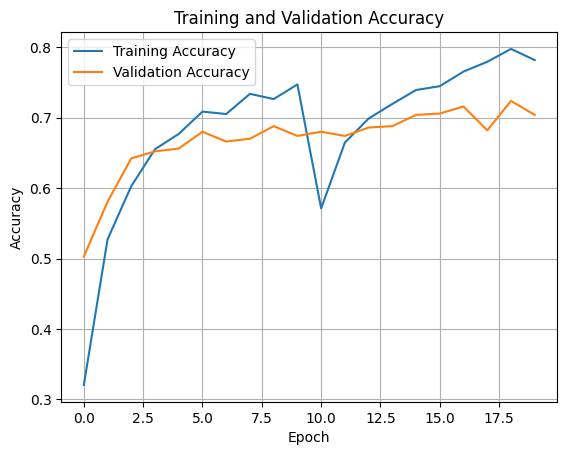

In [9]:
# Combine history
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
model.save('/content/drive/MyDrive/trashnet_model_best.h5')
print("Model saved successfully.")


Model saved successfully.


In [11]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    class_labels = list(train_data.class_indices.keys())
    return class_labels[class_idx]

# Example usage:
print(predict_image('/content/drive/MyDrive/datasets/trashnet/plastic/plastic1.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
glass


In [15]:
# Save the model
model.save("trashnet_modelnew.h5")



In [16]:
from google.colab import files
files.download("trashnet_modelnew.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Overwriting app.py


ERROR:pyngrok.process.ngrok:t=2025-05-20T17:15:11+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: AOHERF25WLCPJMLQF7ASA5XGOEZ3CDYL\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-20T17:15:11+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: AOHERF25WLCPJMLQF7ASA5XGOEZ3CDYL\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-20T17:15:11+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: The authtoken you specified d

PyngrokNgrokError: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: AOHERF25WLCPJMLQF7ASA5XGOEZ3CDYL\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.

In [14]:

# === Improved TrashNet Classifier Training ===

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

# Unfreeze top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Create a new classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Assemble the full model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Compute class weights to handle imbalance
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights_array))

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)
]

# Train the model
history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 794ms/step - accuracy: 0.4963 - loss: 1.4076 - val_accuracy: 0.7575 - val_loss: 0.7189 - learning_rate: 1.0000e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 606ms/step - accuracy: 0.8884 - loss: 0.3826 - val_accuracy: 0.7714 - val_loss: 0.7037 - learning_rate: 1.0000e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 606ms/step - accuracy: 0.9156 - loss: 0.2680 - val_accuracy: 0.7932 - val_loss: 0.6275 - learning_rate: 1.0000e-04
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 646ms/step - accuracy: 0.9000 - loss: 0.2600 - val_accuracy: 0.7694 - val_loss: 0.8025 - learning_rate: 1.0000e-04
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 607ms/step - accuracy: 0.9376 - loss: 0.1998 - val_accuracy: 0.7555 - val_loss: 0.9289 - learning_rate: 1.0000e-04
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 603ms/step - accuracy: 0.9420 - loss: 0.1755 - val_accuracy: 0.7753 - val_loss: 0.8401 - learning_rate: 5.0000e-05
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - acc